# Linear Regression: Overfitting and Regularization

In this notebook, we will observe how linear models overfit using examples, understand why this happens, and learn how to diagnose and control overfitting. We will work with the dataset **"bikes_rent.csv"**, which contains daily calendar information and weather conditions characterizing automated bike rental stations, as well as the number of rentals on each day. Our goal will be to predict the latter; therefore, we will be solving a regression problem.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV

## Task 1

Load the dataset using the `pandas.read_csv` function into the variable `df`. Display the first 5 rows to ensure the data has been read correctly:

In [3]:
# Read the CSV file
df = pd.read_csv('./bikes_rent.csv')

In [4]:
# Output the first five rows
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


For each rental day, the following features are available:

* **_season_**: 1 — Spring, 2 — Summer, 3 — Autumn, 4 — Winter  
* **_yr_**: 0 — 2011, 1 — 2012  
* **_mnth_**: From 1 to 12  
* **_holiday_**: 0 — No holiday, 1 — Holiday  
* **_weekday_**: From 0 to 6  
* **_workingday_**: 0 — Non-working day, 1 — Working day  
* **_weathersit_**: Weather favorability rating from 1 (Clear, nice day) to 4 (Heavy rain, fog)  
* **_temp_**: Temperature in Celsius  
* **_atemp_**: Perceived temperature in Celsius  
* **_hum_**: Humidity  
* **_windspeed(mph)_**: Wind speed in miles per hour  
* **_windspeed(ms)_**: Wind speed in meters per second  
* **_cnt_**: Number of rented bikes (this is the target feature we will predict)

Thus, we have numerical, binary, and nominal (ordinal) features, all of which can be treated as numerical. Nominal features can also be treated as numerical because their order is defined. Let's visualize how the target feature depends on the others using graphs.

Build graphs showing the dependencies of attributes on the number of trips. In other words, 12 graphs need to be created. Each graph should depict the relationship of a specific attribute with the variable `cnt`.

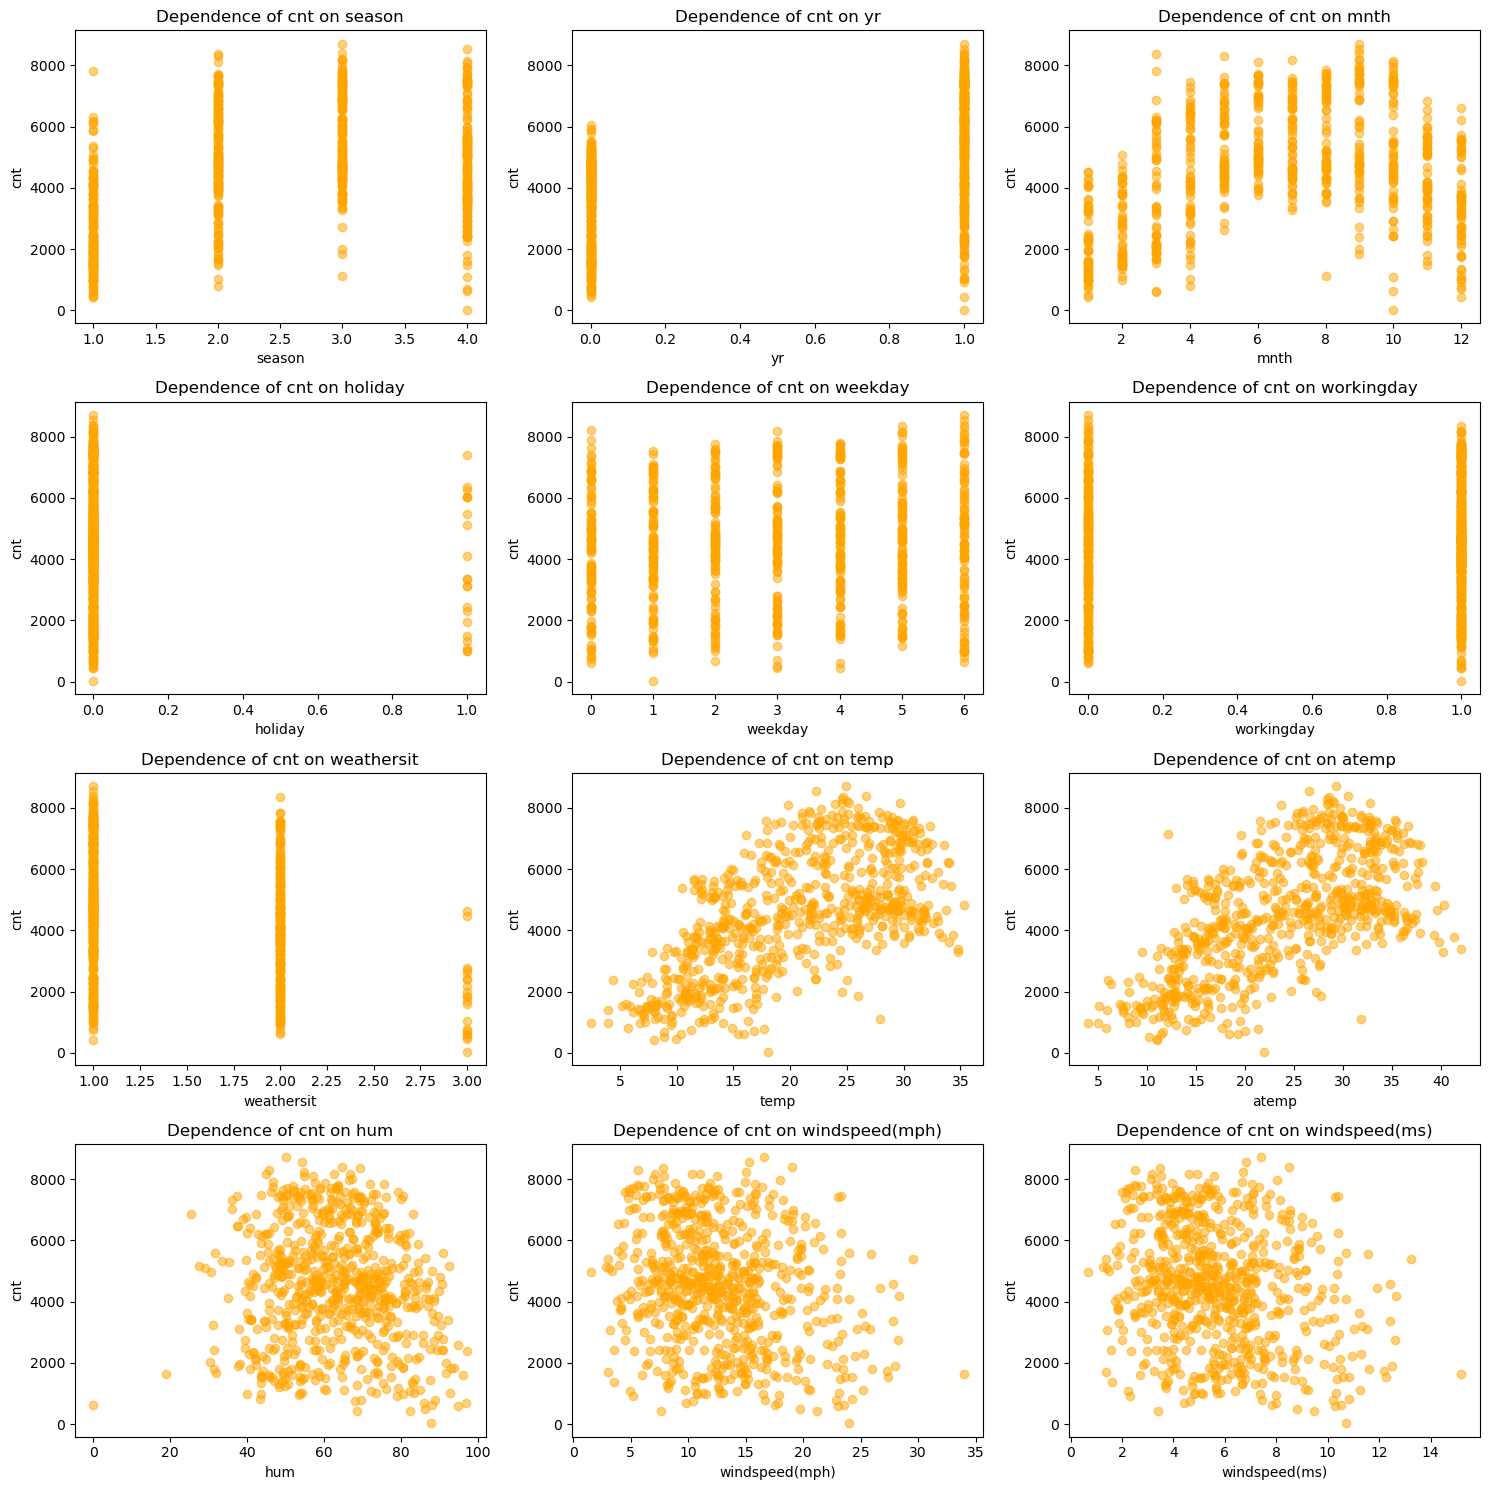

In [5]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.ravel()

for i, col in enumerate(df.columns[:-1]):
    axes[i].scatter(df[col], df['cnt'], alpha=0.5, color='orange')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('cnt')
    axes[i].set_title(f'Dependence of cnt on {col}')

plt.tight_layout()
plt.show()

__Questions:__
1. What is the nature of the dependence of rentals on the month?
2. Name one or two features that the number of rentals is most likely linearly dependent on.

__Answers:__
1. You can observe a logical seasonality: the colder the month, the fewer rentals.
2. I don't see a linear dependence here. It could be argued that there is a dependence on the year, but we only have two years, and in my opinion, that's not enough to talk about the relevance of the sample. The second feature likely refers to temperature (or perceived temperature), but I'm sure if we take newer data with the condition of rising global temperatures, this graph is a parabola because, above 25 degrees Celsius (which is the peak), the demand for bikes decreases.

## Task 2

Let's more rigorously assess the level of linear dependence between the features and the target variable. A good measure of linear dependence between two vectors is the Pearson correlation. Calculate the correlations of all features, except the last one, with the last one using the `corrwith` method.

In [6]:
correlations = df.corrwith(df['cnt'])
print("Correlations between the features and the variable 'cnt':")
print(correlations)

Correlations between the features and the variable 'cnt':
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64


The dataset contains features that correlate with the target variable, so the task can be solved using linear methods.

The graphs show that some features are similar to each other. Therefore, let's also calculate the correlations between the numerical features.

## Task 3

Calculate the pairwise correlations between the features `temp`, `atemp`, `hum`, `windspeed(mph)`, `windspeed(ms)`, and `cnt` using the `corr` method.

In [7]:
correlation_matrix = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
pd.set_option('display.float_format', '{:.2f}'.format)
print("Correlation matrix between numerical features:")
print(correlation_matrix)

Correlation matrix between numerical features:
                temp  atemp   hum  windspeed(mph)  windspeed(ms)   cnt
temp            1.00   0.99  0.13           -0.16          -0.16  0.63
atemp           0.99   1.00  0.14           -0.18          -0.18  0.63
hum             0.13   0.14  1.00           -0.25          -0.25 -0.10
windspeed(mph) -0.16  -0.18 -0.25            1.00           1.00 -0.23
windspeed(ms)  -0.16  -0.18 -0.25            1.00           1.00 -0.23
cnt             0.63   0.63 -0.10           -0.23          -0.23  1.00


The diagonals, as expected, contain ones. However, there are two pairs of highly correlated columns in the matrix: `temp` and `atemp` (correlated by their nature) and the two `windspeed` columns (as they are simply unit conversions of each other). We will see later that this negatively affects the training of the linear model.

Finally, let's look at the means of the features (using the `mean` method) to assess the scale of the features and the proportion of 1s in the binary features.

## Task 4

Display the mean values of the features.

In [8]:
means = df.mean()
print("The mean values of the features:")
print(means)

The mean values of the features:
season              2.50
yr                  0.50
mnth                6.52
holiday             0.03
weekday             3.00
workingday          0.68
weathersit          1.40
temp               20.31
atemp              23.72
hum                62.79
windspeed(mph)     12.76
windspeed(ms)       5.71
cnt              4504.35
dtype: float64


The features have different scales, so it is better to normalize the object-feature matrix for further work.

#### Problem One: Collinear Features

So, in our data, one feature duplicates another, and two more are very similar. Of course, we could immediately remove the duplicates, but let’s see how the model would train if we didn’t notice this issue. First, let’s perform scaling or standardization of the features: subtract the mean from each feature and divide it by the standard deviation. This can be done using the `scale` method. Additionally, it is necessary to shuffle the dataset, as this will be required for cross-validation.

In [9]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Let's train a linear regression model on our data and examine the feature weights.

## Task 5

Create a linear regression object, train it on all the data, and display the model weights (the weights are stored in the `coef_` attribute of the regressor class). You can output pairs of (feature name, weight) using the `zip` function built into Python. The feature names are stored in the `df.columns` variable.

In [10]:
model = LinearRegression()
model.fit(X, y)
for feature, coef in zip(df.columns, model.coef_):
    print(f"{feature}: {coef}")

season: 570.869595873149
yr: 1021.9653490738136
mnth: -141.30480985545685
holiday: -86.75869103934312
weekday: 137.2267452768908
workingday: 56.39044202953192
weathersit: -330.2308549485902
temp: 367.45843785374694
atemp: 585.5720508980754
hum: -145.6086410940602
windspeed(mph): 12458777336271.758
windspeed(ms): -12458777336470.21


We can see that the weights for linearly dependent features are much larger in magnitude than for other features. To understand why this happened, let's recall the analytical formula for calculating the weights of a linear model using the least squares method:

$$w = (X^TX)^{-1} X^T y$$

If there are collinear (linearly dependent) columns in $X$, the matrix $X^TX$ becomes singular, and the formula is no longer valid. The more dependent the features are, the smaller the determinant of this matrix and the worse the approximation $Xw \approx y$. This situation is referred to as the _multicollinearity problem_.

For the pair of variables (temp, atemp), which are slightly less correlated, this did not occur. However, in practice, it is always important to carefully monitor the coefficients when dealing with similar features.

To solve the multicollinearity problem, a regularizer should be used. The $L_1$ or $L_2$ norm of the weights, multiplied by the regularization coefficient $\alpha$, is added to the objective function. In the first case, the method is called Lasso, and in the second case, it is called Ridge.

## Task 6
Let's try training linear models with $L_1$ and $L_2$ regularization and then compare their weights. Train the Ridge and Lasso regressors with default parameters and verify that the issue with the weights has been resolved.

Train a linear model with $L_1$ regularization (Lasso class) and display the weights.

In [12]:
lasso = Lasso().fit(X, y)
print("Lasso regression:")
for feature, coef in zip(df.columns, lasso.coef_):
    print(f"{feature}: {coef}")

Lasso regression:
season: 560.2416160308857
yr: 1019.4634940657195
mnth: -128.73062703678693
holiday: -86.15278133371105
weekday: 137.34789390496329
workingday: 55.21237064135678
weathersit: -332.3698569623487
temp: 376.36323620969864
atemp: 576.530793504551
hum: -144.12915500348578
windspeed(mph): -197.1396894024843
windspeed(ms): -2.805139889577359e-08


Train a linear model with $L_2$ regularization (Ridge class) and display the weights.

In [14]:
ridge = Ridge().fit(X, y)
print("\nRidge regression:")
for feature, coef in zip(df.columns, ridge.coef_):
    print(f"{feature}: {coef}")


Ridge regression:
season: 563.0645722520159
yr: 1018.948378787529
mnth: -131.87332028247553
holiday: -86.74609799709262
weekday: 138.00511117871886
workingday: 55.903110375064365
weathersit: -332.3497884990727
temp: 386.4578891919364
atemp: 566.3470470600394
hum: -145.0713272986727
windspeed(mph): -99.25944108185699
windspeed(ms): -99.25944115427635


## Task 7

Unlike $L_2$ regularization, $L_1$ regularization zeros out the weights for some features. Let's observe how the weights change as the regularization coefficient $\alpha$ increases.

For each value of the coefficient in `alphas`, train the `Lasso` regressor and store the weights in the `coefs_lasso` list. Then, train the `Ridge` regressor and store the weights in the `coefs_ridge` list. Convert the resulting lists into `np.array`.

In [15]:
alphas = np.arange(1, 500, 50)
coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha).fit(X, y)
    ridge = Ridge(alpha=alpha).fit(X, y)
    coefs_lasso.append(lasso.coef_)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Analyze the dynamics of the weights as the regularization parameter increases:

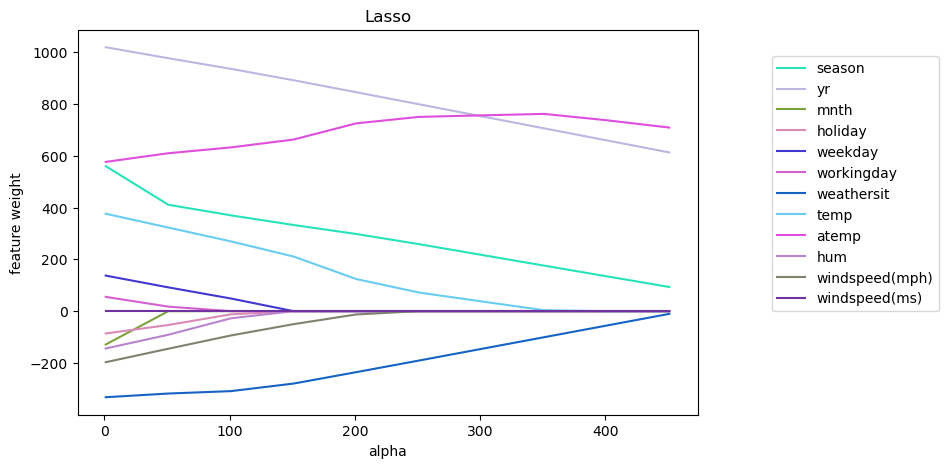

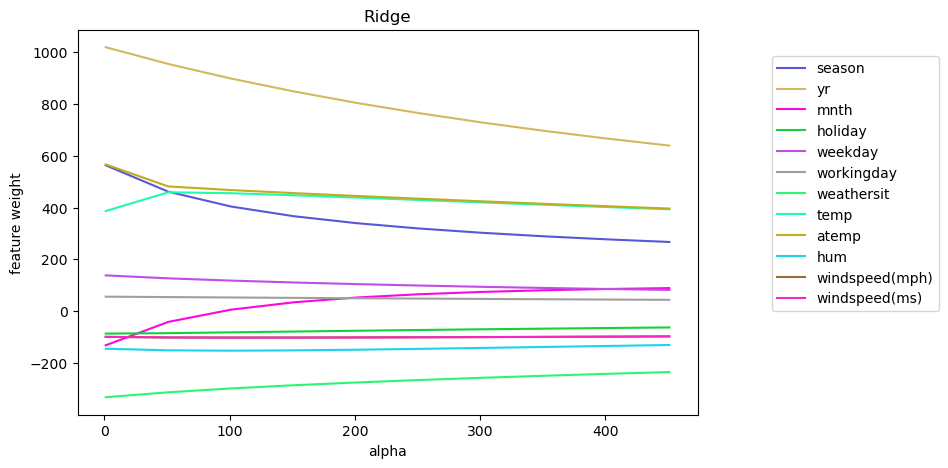

In [16]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

**Analyze the graphs and answer the following questions:**

1. Which regularizer (Ridge or Lasso) reduces the weights more aggressively for the same alpha value?
2. What happens to the weights in Lasso if alpha is made very large? Explain why this happens.
3. Can we say that Lasso excludes one of the `windspeed` features for any `alpha` > 0? What about Ridge? A feature is considered excluded if its coefficient is less than $10^{-3}$.
4. Which regularizer is better for feature selection of non-informative features?

**Answers:**

1. **Lasso** reduces the weights more aggressively for the same alpha value.
2. If alpha is made very large in **Lasso**, most or all of the feature weights will approach zero. This happens because L1 regularization adds a penalty to the loss function that is proportional to the sum of the absolute values of the coefficients. A large alpha makes this penalty so significant that the model will attempt to reduce all coefficients to zero in order to minimize the total cost of the function.
3. 
   - **Lasso**: Yes, we can say that Lasso excludes one of the `windspeed` features (specifically `windspeed(ms)`) when alpha > 0, as the weights for `windspeed(ms)` are already close to zero at very small alpha values.
   - **Ridge**: No, Ridge does not fully exclude features. Even for large values of alpha, the weights for the `windspeed(mph)` and `windspeed(ms)` features remain small but not zero. This is because Ridge imposes a penalty on the sum of the squares of the coefficients, which reduces their values but does not completely nullify them.
4. **Lasso** (L1 regularization) is better for feature selection of non-informative features because it can zero out the weights of unimportant variables, effectively removing them from the model. **Ridge** (L2 regularization) reduces the weights of features but does not fully eliminate them.

**Overall conclusion**

Based on the graphs, we can conclude that **Lasso** is a better tool for excluding non-informative features from the model due to its ability to zero out the weights. **Ridge**, on the other hand, is more suitable for models where all features are important but may have coefficients that need to be adjusted to avoid being too large or too small.

## Task 8

Next, we will work with **Lasso**.
We can see that, as alpha changes, the model selects feature coefficients differently. Now, we need to choose the best alpha.

To do this, first, we need a quality metric. We will use the optimized cost function of the least squares method, namely, the **Mean Squared Error (MSE)**, as our metric.

Second, we need to determine on which data to calculate this metric. We cannot choose alpha based on the MSE of the training set, because then we will not be able to assess how the model will make predictions on new data. If we choose one split of the data into training and test sets (this is called holdout), we will adjust to those specific "new" data and may overfit. Therefore, we will perform multiple splits, testing different alpha values on each, and then average the MSE. The most convenient way to do this is through **cross-validation**: divide the dataset into **K** parts, and each time take one part as the test set, using the remaining blocks to form the training set.

Performing cross-validation for regression in sklearn is quite simple: there is a dedicated regressor, **LassoCV**, which takes a list of alphas as input and computes the MSE for each alpha using cross-validation. After training (if you leave the default parameter `cv=3`), the regressor will contain the variable **mse_path_**, a matrix of size `len(alpha) x k`, where `k=3` (the number of folds in cross-validation), containing the MSE values on the test for each run. Additionally, the variable **alpha_** will store the chosen regularization parameter, and **coef_** will store the learned weights corresponding to this `alpha_`.

Note that the regressor may change the order in which it processes the alphas; for matching with the MSE matrix, it is better to use the **alphas_** variable of the regressor.

Train the `LassoCV` regressor on all regularization parameters from alpha. Then, plot the _mean_ MSE over rows depending on alpha (use the `create_plot` function for this).

Output the selected `alpha`, as well as the "feature-coefficient" pairs for the trained coefficients vector.

In [17]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # Converting map objects to lists for plotting
    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [18]:
alphas = np.arange(1, 100, 5)
regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)
mse_means = np.mean(regressor.mse_path_, axis=1)

print("The selected value of alpha:", regressor.alpha_)
print("Coefficients:")

for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {coef}")

The selected value of alpha: 6
Coefficients:
season: 532.0189828413535
yr: 1015.0602226430597
mnth: -100.03952614356628
holiday: -83.2939598752991
weekday: 132.50446549095793
workingday: 51.55708561407379
weathersit: -330.5598567399813
temp: 370.6798550300328
atemp: 581.3969310654992
hum: -140.00740550068875
windspeed(mph): -191.7714084713494
windspeed(ms): -2.685570636704926e-08


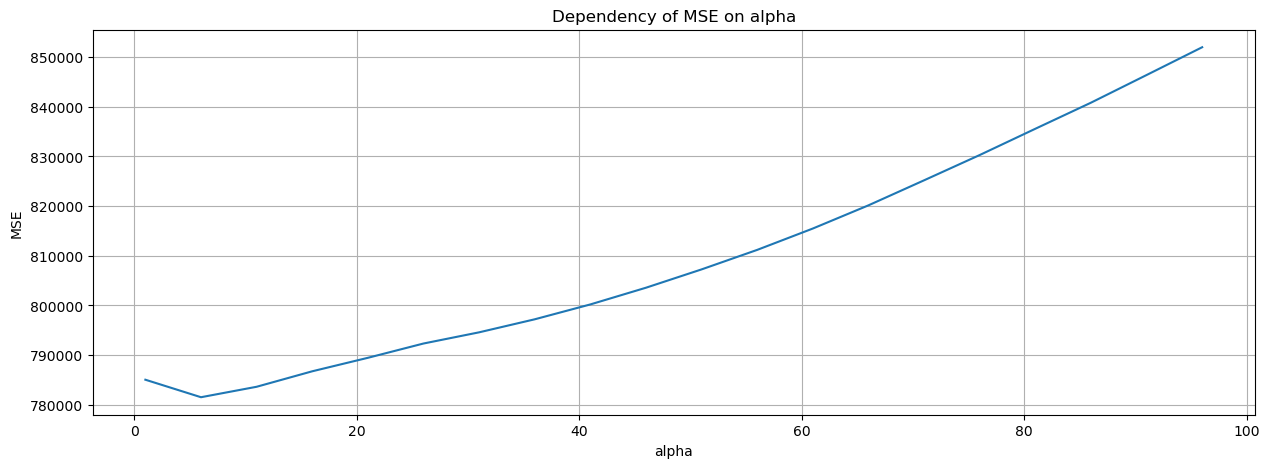

In [20]:
create_plot(list(zip(regressor.alphas_, mse_means)), title="Dependency of MSE on alpha", xlabel="alpha", ylabel="MSE")

So, we have chosen a specific regularization parameter. Let's see which alpha we would select if we split the dataset only once into training and testing, that is, let's examine the MSE trajectories corresponding to the individual blocks of the dataset.

## Task 9

Display the values of `alpha` that correspond to the minimum `MSE` on each split (i.e., by columns).  
Visualize the columns of `mse_path_` on three separate plots.

The values of alpha that correspond to the minima of MSE on each split:
Split 1: Alpha = 6, MSE = 733725.7604052246
Split 2: Alpha = 1, MSE = 799433.1673691698
Split 3: Alpha = 51, MSE = 796979.8955193639


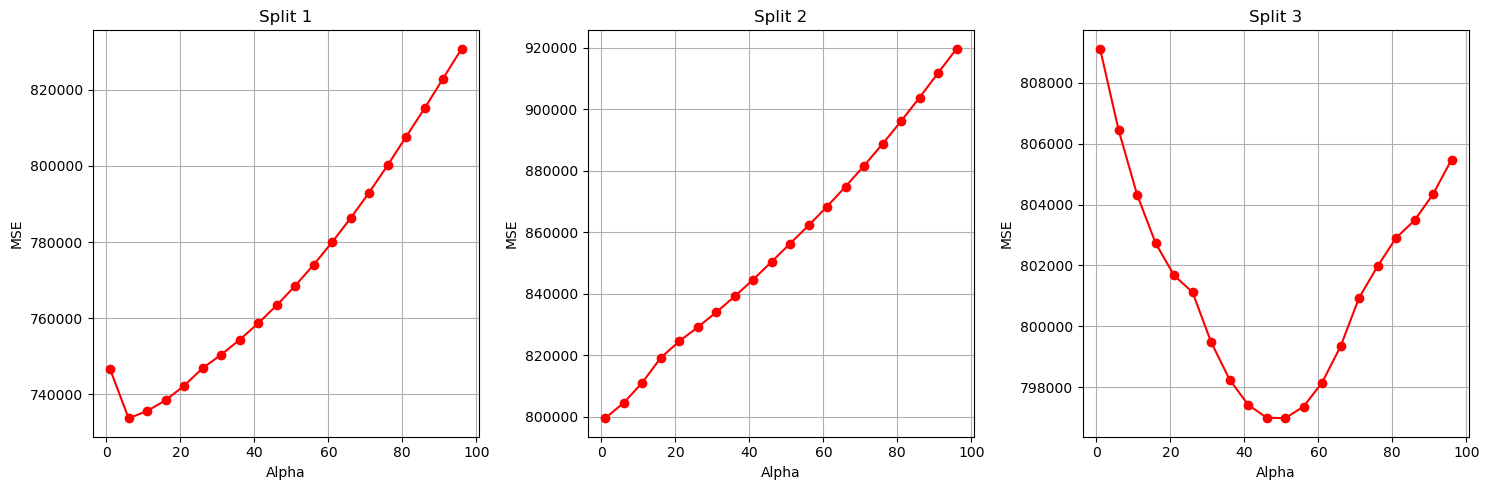

In [19]:
alphas_min_mse = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]
mse_min_values = np.min(regressor.mse_path_, axis=0)

print("The values of alpha that correspond to the minima of MSE on each split:")
for i, (alpha, mse) in enumerate(zip(alphas_min_mse, mse_min_values)):
    print(f"Split {i+1}: Alpha = {alpha}, MSE = {mse}")

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], marker='o', color='red')
    plt.title(f'Split {i+1}')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.grid(True)

plt.tight_layout()
plt.show()

For each split, the optimal value of `alpha` is different, and it corresponds to a large MSE on the other splits. This means that we are tuning for specific training and validation sets. When choosing `alpha` via cross-validation, we are selecting a more "average" value that will give an acceptable metric across different splits of the data.

## Task 10

Finally, as is customary in data analysis, let's interpret the results. Answer the following questions.

#### Question 1

In the last trained model, select 4 features with the largest (positive) coefficients (and write them down). Look at the visualizations of the relationships between `cnt` and these features, which we displayed in the "Data Exploration" block. Can you observe a growing linear relationship between `cnt` and these features on the graphs? Does it make sense (based on common sense) to state that the higher the values of these features, the more people will want to rent bikes?

#### Answer:

The features with the largest positive coefficients are: **yr**: 2036.23 | **season**: 506.55 | **workingday**: 118.45 | **weekday**: 68.94

- `yr`: The coefficient for `yr` (year) is the largest. This means that in 2012 (denoted as 1), the number of bike rentals is significantly higher than in 2011 (denoted as 0). This makes sense, as the bike-sharing system may have developed over time, leading to more rentals.

- `season`: has the second-largest positive coefficient. This suggests that the number of rentals increases during certain seasons, such as summer or spring, when the weather is better and more people are likely to rent bikes. This also makes sense based on common sense.

- `workingday`: A positive coefficient for `workingday` means that the number of bike rentals increases on workdays. This could be related to the use of bikes as a means of transportation to work.

- `weekday`: A positive coefficient for `weekday` indicates that the number of rentals varies depending on the day of the week. While the relationship might be weaker, it still shows that certain days of the week (e.g., mid-week) may be more popular for bike rentals.

**Conclusion**: 

Yes, it can be stated that the higher the values of these features, the more people will want to rent bikes. This aligns with common sense and is confirmed by the graphs.

#### Question 2

Select 3 features with the largest negative coefficients by absolute value (and list them), then look at the corresponding visualizations. Can you see a decreasing linear relationship? Is it logical to say that the larger the value of these features, the fewer people will want to rent bikes?

#### Answer:

The features with the largest negative coefficients by absolute value are: **weathersit**: -604.57 | **holiday**: -484.65 | **windspeed (mph)**: -38.34

- `weathersit`: The negative coefficient indicates that as the weather worsens (the value of `weathersit` increases), the number of bike rentals decreases. This is logical, as fewer people are likely to rent bikes in bad weather conditions (e.g., rain or fog).
  
- `holiday`: The negative coefficient for `holiday` suggests that bike rentals decrease on holidays. This may be because people tend to travel less or use other forms of transportation during holiday periods.

- `windspeed (mph)`: The negative coefficient for wind speed indicates that as wind speed increases, the number of bike rentals decreases. This also makes sense, as strong winds may make biking less comfortable.

**Conclusion**: 

Yes, it is logical to say that the larger the value of these features, the fewer people will want to rent bikes. This aligns with real-world expectations and is confirmed by the visualizations.

#### Question 3

List the features with coefficients close to zero (< 1e-3). Why do you think the model excluded them (look at the plots again)? Is it true that they have no impact on bike demand?

#### Answer:

**windspeed(ms)**: -0.0

The feature `windspeed(ms)` has a coefficient of 0. This means that the model excluded this feature because it is perfectly correlated with the feature `windspeed(mph)` (wind speed in miles per hour). Both features convey the same information, just in different units, so the model kept only one of them (`windspeed(mph)`).

**Conclusion**: The feature `windspeed(ms)` does not affect bike demand because its information is already captured by the other feature `windspeed(mph)`.

### Conclusion

So, we have seen how to monitor the adequacy of a linear model, how to select features, and how to properly, if possible, select the regularization coefficient without overfitting to a specific portion of the data.

It is worth noting that cross-validation is convenient for selecting only a small number of parameters (1, 2, or at most 3) because for each possible combination, we need to train the model multiple times. This process takes a lot of time, especially when training on large datasets.